In [1]:
# import libraries
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
# kaggle cleaned data
toxic_comments = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Big Armor/toxic-train-kaggle-clean.csv")

In [3]:
print(toxic_comments.shape)
toxic_comments.head()

(159571, 7)


,toxic,severe_toxic,obscene,threat,insult,identity_hate,word_splits
0,0,0,0,0,0,0,"['explanation', 'why', 'the', 'edits', 'made',..."
1,0,0,0,0,0,0,"[""d'aww"", '!', 'he', 'matches', 'this', 'backg..."
2,0,0,0,0,0,0,"['hey', 'man', ',', ""i'm"", 'really', 'not', 't..."
3,0,0,0,0,0,0,"['more', 'i', ""can't"", 'make', 'any', 'real', ..."
4,0,0,0,0,0,0,"['you', ',', 'sir', ',', 'are', 'my', 'hero', ..."


In [ ]:
filter = toxic_comments["word_splits"] != ""
toxic_comments = toxic_comments[filter]
toxic_comments = toxic_comments.dropna()

In [5]:
print(toxic_comments["word_splits"][168])
print("Toxic:" + str(toxic_comments["toxic"][168]))
print("Severe_toxic:" + str(toxic_comments["severe_toxic"][168]))
print("Obscene:" + str(toxic_comments["obscene"][168]))
print("Threat:" + str(toxic_comments["threat"][168]))
print("Insult:" + str(toxic_comments["insult"][168]))
print("Identity_hate:" + str(toxic_comments["identity_hate"][168]))

['you', 'should', 'be', 'fire', 'd', ',', "you're", 'a', 'moron', 'ic', 'wimp', 'who', 'is', 'too', 'lazy', 'to', 'do', 'research', '.', 'it', 'makes', 'me', 'sick', 'that', 'people', 'like', 'you', 'exist', 'in', 'this', 'world', '.']
Toxic:1
Severe_toxic:0
Obscene:0
Threat:0
Insult:1
Identity_hate:0


In [6]:
toxic_comments_labels = toxic_comments[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
toxic_comments_labels.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


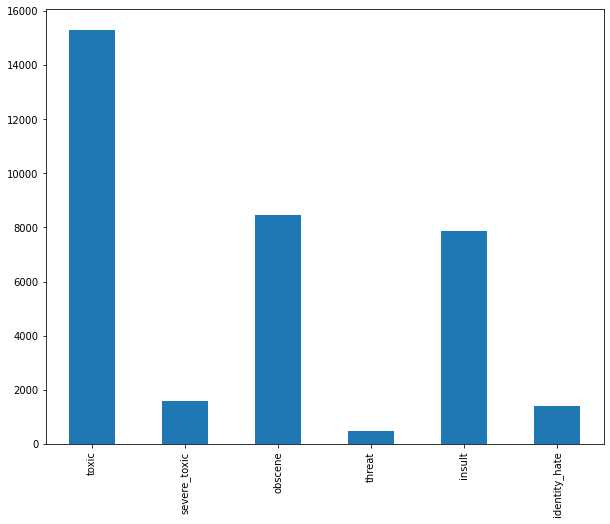

In [8]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

toxic_comments_labels.sum(axis=0).plot.bar();

In [ ]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [ ]:
X = []
sentences = list(toxic_comments["word_splits"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = toxic_comments_labels.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('/content/drive/My Drive/Colab Notebooks/Big Armor/GloVe/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(6, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [18]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          14315400  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 14,433,422
Trainable params: 118,022
Non-trainable params: 14,315,400
_________________________________________________________________
None


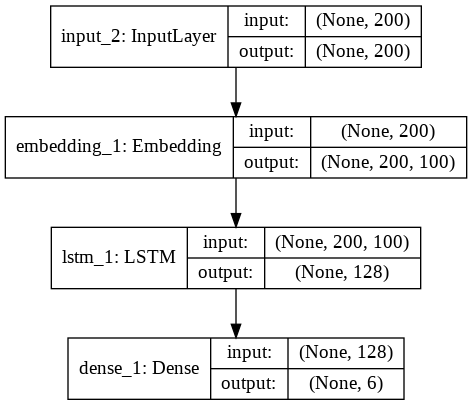

In [19]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [20]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/5
102124/102124 [==============================] - 234s 2ms/step - loss: 0.1368 - acc: 0.9644 - val_loss: 0.0838 - val_acc: 0.9737
Epoch 2/5
102124/102124 [==============================] - 232s 2ms/step - loss: 0.0649 - acc: 0.9777 - val_loss: 0.0599 - val_acc: 0.9791
Epoch 3/5
102124/102124 [==============================] - 235s 2ms/step - loss: 0.0554 - acc: 0.9805 - val_loss: 0.0538 - val_acc: 0.9808
Epoch 4/5
102124/102124 [==============================] - 233s 2ms/step - loss: 0.0515 - acc: 0.9816 - val_loss: 0.0522 - val_acc: 0.9812
Epoch 5/5
102124/102124 [==============================] - 235s 2ms/step - loss: 0.0497 - acc: 0.9821 - val_loss: 0.0514 - val_acc: 0.9813


In [21]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

31915/31915 [==============================] - 26s 804us/step
Test Score: 0.05026458348718796
Test Accuracy: 0.9818843603134155


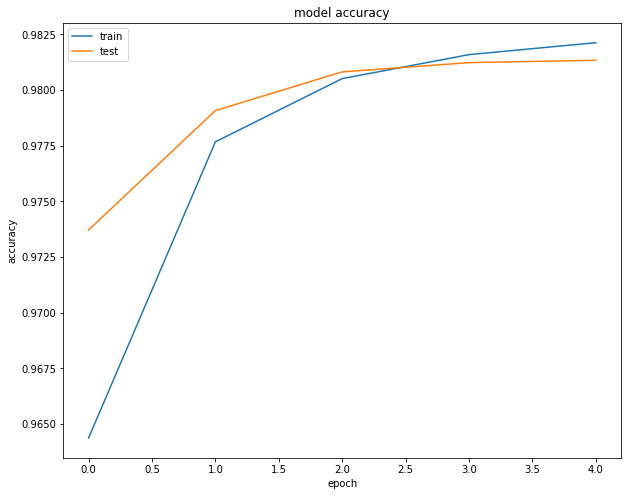

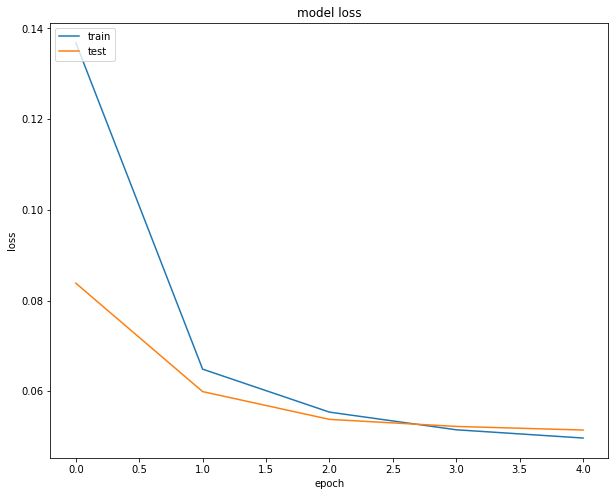

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [ ]:
X = []
sentences = list(toxic_comments["word_splits"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = toxic_comments[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
# First output
y1_train = y_train[["toxic"]].values
y1_test =  y_test[["toxic"]].values

# Second output
y2_train = y_train[["severe_toxic"]].values
y2_test =  y_test[["severe_toxic"]].values

# Third output
y3_train = y_train[["obscene"]].values
y3_test =  y_test[["obscene"]].values

# Fourth output
y4_train = y_train[["threat"]].values
y4_test =  y_test[["threat"]].values

# Fifth output
y5_train = y_train[["insult"]].values
y5_test =  y_test[["insult"]].values

# Sixth output
y6_train = y_train[["identity_hate"]].values
y6_test =  y_test[["identity_hate"]].values

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
glove_file = open('/content/drive/My Drive/Colab Notebooks/Big Armor/GloVe/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
input_1 = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_1)
LSTM_Layer1 = LSTM(128)(embedding_layer)

output1 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output2 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output3 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output4 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output5 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output6 = Dense(1, activation='sigmoid')(LSTM_Layer1)

model = Model(inputs=input_1, outputs=[output1, output2, output3, output4, output5, output6])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [31]:
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 200, 100)     14315400    input_3[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 128)          117248      embedding_2[0][0]                
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1)            129         lstm_2[0][0]                     
____________________________________________________________________________________________

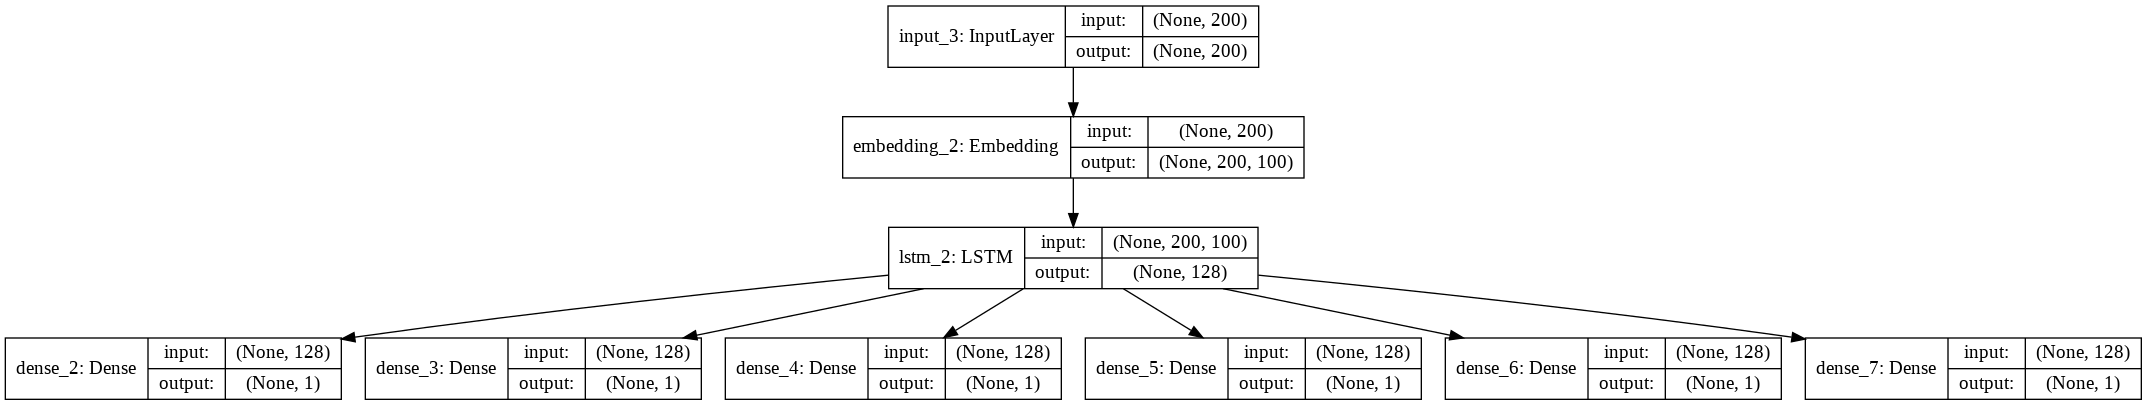

In [32]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4b.png', show_shapes=True, show_layer_names=True)

In [33]:
history = model.fit(x=X_train, y=[y1_train, y2_train, y3_train, y4_train, y5_train, y6_train], batch_size=8192, epochs=5, verbose=1, validation_split=0.2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/5
102124/102124 [==============================] - 8s 76us/step - loss: 3.3698 - dense_2_loss: 0.5847 - dense_3_loss: 0.5397 - dense_4_loss: 0.5552 - dense_5_loss: 0.5257 - dense_6_loss: 0.5327 - dense_7_loss: 0.5373 - dense_2_acc: 0.9040 - dense_3_acc: 0.9775 - dense_4_acc: 0.9393 - dense_5_acc: 0.9902 - dense_6_acc: 0.9458 - dense_7_acc: 0.9820 - val_loss: 0.9964 - val_dense_2_loss: 0.3192 - val_dense_3_loss: 0.0978 - val_dense_4_loss: 0.2157 - val_dense_5_loss: 0.0726 - val_dense_6_loss: 0.2019 - val_dense_7_loss: 0.0970 - val_dense_2_acc: 0.9036 - val_dense_3_acc: 0.9901 - val_dense_4_acc: 0.9468 - val_dense_5_acc: 0.9966 - val_dense_6_acc: 0.9509 - val_dense_7_acc: 0.9901
Epoch 2/5
102124/102124 [==============================] - 7s 70us/step - loss: 0.9019 - dense_2_loss: 0.3284 - dense_3_loss: 0.0648 - dense_4_loss: 0.2078 - dense_5_loss: 0.0350 - dense_6_loss: 0.2023 - dense_7_loss: 0.0590 - dense_2_acc: 0.9044 - dense_

In [34]:
score = model.evaluate(x=X_test, y=[y1_test, y2_test, y3_test, y4_test, y5_test, y6_test], verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

31915/31915 [==============================] - 29s 916us/step
Test Score: 0.847177982800959
Test Accuracy: 0.3144482672214508


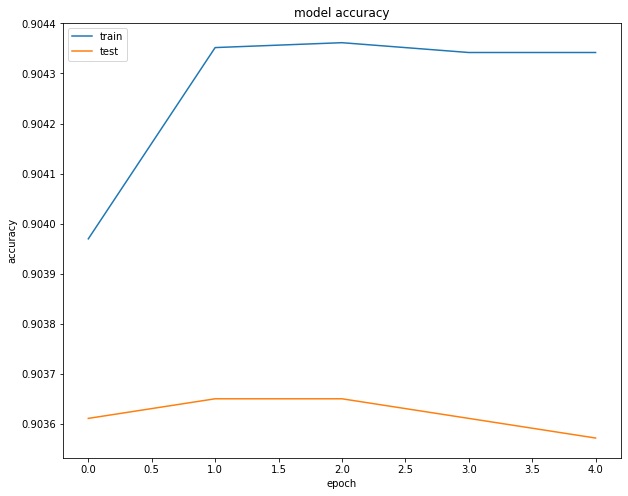

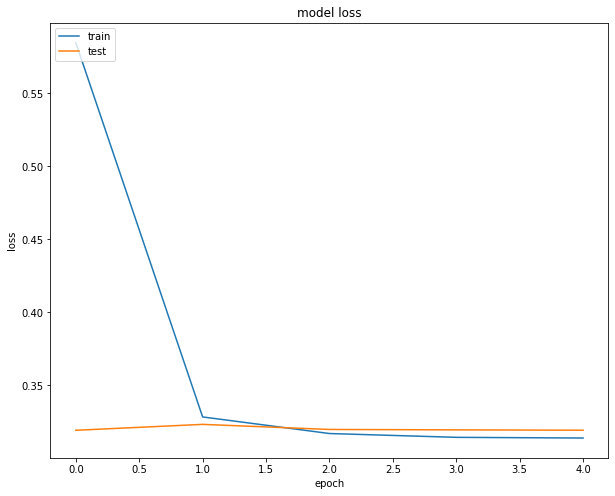

In [37]:
import matplotlib.pyplot as plt

plt.plot(history.history['dense_2_acc'])
plt.plot(history.history['val_dense_2_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['dense_2_loss'])
plt.plot(history.history['val_dense_2_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()